## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import strptime
import datetime
from datetime import datetime
import math
import warnings
warnings.filterwarnings('ignore')
import time
import csv
import glob
import logging
import importlib
import tweets_utils
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
from operator import itemgetter
import matplotlib.cm as mcm
import community
from community import community_louvain as cm
import leidenalg as la
import igraph as ig
from cdlib import algorithms
import plotly.express as px
%autosave 3600

Autosaving every 3600 seconds


## Indice
- [Utils](#utils)
- [CCDH and tweets process](#ccdh)
- [Process CCDH data](#Process_CCDH_data)
- [New files](#new)
- [Total stats](#stats) 
- [Stats disinform](#stats_disinform)
- [New domain study](#new_urls)
- [Credibility](#credibility)
- [Date tweets](#dates)
- [Network](#network)

## Utils
<a id="utils"/>

In [2]:
path = "C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/"
users_link = glob.glob(path + "users_ccdh.csv")
users_disinform = pd.read_csv(users_link[0])
users_disinform

,screen_name,status
0,mercola,active
1,RobertKennedyJr,active
2,BusyDrT,suspended
3,DrButtar,active
4,unhealthytruth,active
5,DrChrisNorthrup,active
6,DrBenTapper1,suspended
7,kevdjenkins1,active


In [3]:
def found(name, list_name=users_disinform["screen_name"]):
    for i in list_name:
        if(name == i):
            return True
    return False

In [4]:
path = "C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/"
credibility_url = pd.read_csv(path + "domain_credibility.csv")
credibility_url

,Domain,Class
0,100percentfedup.com,low
1,100percentfedup.com,high
2,10news.one,low
3,12minutos.com,low
4,12news.com,high
...,...,...
820,childrenshealthdefense.org,low
821,"AdvancedMedicineConference.com,",low
822,aol.com,high
823,trendingpolitics.com,low


## CCDH Research
<a id="ccdh"/>

### Process CCDH data
<a id="Process_CCDH_data"/>

In [5]:
path = "C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/"
disinform = pd.read_csv(path + "disinformation_users.csv")
disinform

,screen_name,status
0,mercola,active
1,RobertKennedyJr,active
2,TyCharleneB,removed
3,BusyDrT,suspended
4,IslamRizza,removed
5,DrButtar,active
6,unhealthytruth,active
7,sayerjigmi,active
8,KellyBroganMD,active
9,DrChrisNorthrup,active


In [12]:
retweet_name = []
retweet_id = []
retweeted_name = []
retweeted_id = []
rt_link = []

tweet_name = []
tweet_id = []

# reply_id = []
# reply_name = []
# replied_id = []
# replied_name = []

link = []
result = []

# total_len = 0
# original_len = 0
# retweet_len = 0
# reply_len = 0
# d_total_len = 0
# d_original_len = 0
# d_retweet_len = 0
# d_reply_len = 0

cols_tweets = [u'id', u'user_screen_name',u'user_id', u'created_at', 
               u'urls', u"rt_created_at", u"rt_user_id", 
               u"rt_user_screen_name", u'in_reply_to_user_id', 
               u'in_reply_to_screen_name', u'in_reply_to_status_id']

files_tweets = glob.glob("F:/COVID-19-Tweets/*/tweets.csv")

In [14]:
for chunk in pd.read_csv(files_tweets[0], usecols=cols_tweets, chunksize=10, lineterminator = '\n'):
    break
chunk.head()

,id,created_at,user_id,user_screen_name,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,rt_created_at,rt_user_id,rt_user_screen_name,urls
0,1219752899636613121,Tue Jan 21 22:45:27 +0000 2020,1110906564158869505,Huerconetzin,NaN,NaN,NaN,Tue Jan 21 19:09:49 +0000 2020,1.865051e+07,AnneKPIX,[]
1,1219768733310291969,Tue Jan 21 23:48:22 +0000 2020,1214557289606242304,JustAnotherAme4,NaN,NaN,NaN,Tue Jan 21 21:33:16 +0000 2020,2.097571e+06,cnni,[]
2,1219768903116607488,Tue Jan 21 23:49:03 +0000 2020,426033838,HHSRegion8,NaN,NaN,NaN,Tue Jan 21 20:57:06 +0000 2020,1.465700e+08,CDCgov,[]
3,1219753863940648965,Tue Jan 21 22:49:17 +0000 2020,2252416118,Paxman42,NaN,NaN,NaN,Tue Jan 21 22:20:07 +0000 2020,7.865932e+17,OurWarOnCancer,[]
4,1219755288988798981,Tue Jan 21 22:54:57 +0000 2020,738000529775697920,beerhowell,NaN,NaN,NaN,Tue Jan 21 18:37:41 +0000 2020,8.070950e+05,nytimes,[]


In [33]:
importlib.reload(tweets_utils)
start_time = time.perf_counter()
j = 0
for filename in files_tweets:
    print(f"Reading file: {filename}")
    result.extend(tweets_utils.process_all_data(filename, cols_tweets, True, users_disinform["screen_name"]))
    lista = result[j]
    j = j + 1
    print(f"Mese numero {j}")
#     x = 0
#     y = 0
    for i in range(len(lista)):
        #original post
        id_tweet.extend(lista[i]["id"])
        tweet_name.extend(lista[i]["original_names"])
        tweet_id.extend(lista[i]["original_ids"])
        link.extend(lista[i]["links"])
#         #user who retweet
        retweet_name.extend(lista[i]["retweet_users"])
        retweet_id.extend(lista[i]["retweet_ids"])
#         #user retweeted
        retweeted_name.extend(lista[i]["retweeted_users"])
        retweeted_id.extend(lista[i]["retweeted_ids"])
        rt_link.extend(lista[i]["rt_link"])
#         #user who reply
        reply_id.extend(lista[i]["reply_ids"])
        reply_name.extend(lista[i]["reply_users"])
#         #use who get reply
        replied_id.extend(lista[i]["replied_ids"])
        replied_name.extend(lista[i]["replied_users"])
#         #len
#         total_len = total_len + lista[i]["total_len"]
#         original_len = original_len + lista[i]["original_len"]
#         retweet_len = retweet_len + lista[i]["retweet_len"]
#         reply_len = reply_len + lista[i]["reply_len"]
        
#         d_total_len = d_total_len + lista[i]["d_total_len"]
#         d_original_len = d_original_len + lista[i]["d_original_len"]
#         d_retweet_len = d_retweet_len + lista[i]["d_retweet_len"]
#         d_reply_len = d_reply_len + lista[i]["d_reply_len"]
#         print(i)
#         print("-")
#         if(i == 0):
#             x = 0
#         else:
#             x = y
#         y = x + len(lista[i]["users"])
#         for q in range(x,y):
#             if(found(lista[i]["users"][q])):          
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

Reading file: F:/COVID-19-Tweets\2020-01\tweets.csv
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Mese numero 1
Reading file: F:/COVID-19-Tweets\2020-02\tweets.csv
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Mese numero 2
Reading file: F:/COVID-19-Tweets\2020-03\tweets.csv
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Processing chunk 13
Processing chunk 14
Processing chunk 15
Mese numero 3
Reading file: F:/COVID-19-Tweets\2020-04\tweets.csv
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7


In [34]:
del result
del lista

In [35]:
df_rt_ccdh = pd.DataFrame(list(zip(id_tweet, retweet_id, retweet_name, retweeted_id, retweeted_name, 
      rt_link, replied_id, replied_name)), 
      columns =['id', 'user_id', 'name', 'rt_id','rt_name', 'rt_url', 'rp_id', 'rp_name'])

In [74]:
gephi = pd.DataFrame(list(zip(retweet_name, retweeted_name)), 
                          columns =['name','rt_name'])
gephi.to_csv("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/gephi.csv", index=False)

In [42]:
df_rt_ccdh.to_csv("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/ccdh_user_rt.csv", index=False)

In [43]:
df_rt_ccdh

,id,name,rt_id,rt_name,rt_url
0,1.104760e+18,Exvaxxer_Mommy,18093097.0,unhealthytruth,[]
1,1.055931e+18,patriot7842,18093097.0,unhealthytruth,[]
2,2.282256e+07,dihoppy,18093097.0,unhealthytruth,[]
3,4.182128e+07,liteseeker,18093097.0,unhealthytruth,[]
4,7.150825e+08,Heidi559Heidi,18093097.0,unhealthytruth,[]
...,...,...,...,...,...
3524,1.163569e+18,Nomoresilence20,337808606.0,RobertKennedyJr,[]
3525,1.082425e+18,Warrior17761,35013035.0,BusyDrT,[]
3526,8.863322e+06,TonyGosling,337808606.0,RobertKennedyJr,[]
3527,1.206716e+18,banka_beata,35013035.0,BusyDrT,[]


### New file
<a id="new"/>

In [26]:
path = "C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/"
ccdh_tweets = pd.read_csv(path + "disinformation_tweets.csv")

In [27]:
ccdh_tweets

,id,id_str,created_at,user_id,user_screen_name,user_verified,user_created_at,user_tweets_count,user_friends_count,user_followers_count,...,quoted_status_text,quoted_status_created_at,quoted_user_id,quoted_user_created_at,hashtags,symbols,user_mentions,urls,polls,media
0,1422926560412127235,1422926560412127235,2021-08-04 14:25:03+00:00,12524522,mercola,False,Tue Jan 22 05:37:28 +0000 2008,79565,28932,303072,...,NaN,NaN,NaN,NaN,[],[],[],"[{'url': 'https://t.co/RyPNO87E0m', 'expanded_...",[],"[{'id': 1422926558931550210, 'id_str': '142292..."
1,1422649949616017409,1422649949616017409,2021-08-03 20:05:54+00:00,12524522,mercola,False,Tue Jan 22 05:37:28 +0000 2008,79564,28932,303072,...,NaN,NaN,NaN,NaN,[],[],[],"[{'url': 'https://t.co/zYFhJSPGxj', 'expanded_...",[],[]
2,1422639392460521477,1422639392460521477,2021-08-03 19:23:57+00:00,12524522,mercola,False,Tue Jan 22 05:37:28 +0000 2008,79563,28932,303072,...,NaN,NaN,NaN,NaN,[],[],[],"[{'url': 'https://t.co/SpkCAmlljD', 'expanded_...",[],[]
3,1422635443812720642,1422635443812720642,2021-08-03 19:08:15+00:00,12524522,mercola,False,Tue Jan 22 05:37:28 +0000 2008,79562,28932,303072,...,BREAKING NEWS: soon proof of #COVID19 vaccine ...,Tue Aug 03 14:20:01 +0000 2021,250884927.0,Sat Feb 12 00:43:55 +0000 2011,[],[],[],"[{'url': 'https://t.co/wBdNNdN0Iv', 'expanded_...",[],[]
4,1422635145262247941,1422635145262247941,2021-08-03 19:07:04+00:00,12524522,mercola,False,Tue Jan 22 05:37:28 +0000 2008,79561,28932,303072,...,Substack doubles down on uncensored 'free spee...,Tue Aug 03 15:53:28 +0000 2021,816653.0,Wed Mar 07 01:27:09 +0000 2007,[],[],[],"[{'url': 'https://t.co/oNfgM4iMXy', 'expanded_...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22210,750035463457607680,750035463457607680,2016-07-04 18:36:04+00:00,3981743673,kevdjenkins1,False,Sat Oct 17 19:50:10 +0000 2015,208,482,826,...,NaN,NaN,NaN,NaN,[],[],[],"[{'url': 'https://t.co/ygIb8pl6ei', 'expanded_...",[],[]
22211,748161074101354496,748161074101354496,2016-06-29 14:27:54+00:00,3981743673,kevdjenkins1,False,Sat Oct 17 19:50:10 +0000 2015,207,482,826,...,NaN,NaN,NaN,NaN,[],[],[],[],[],[]
22212,747624560686678016,747624560686678016,2016-06-28 02:56:00+00:00,3981743673,kevdjenkins1,False,Sat Oct 17 19:50:10 +0000 2015,206,482,826,...,NaN,NaN,NaN,NaN,[],[],"[{'screen_name': 'kevdjenkins1', 'name': 'Kevi...",[],[],[]
22213,747598980712890368,747598980712890368,2016-06-28 01:14:21+00:00,3981743673,kevdjenkins1,False,Sat Oct 17 19:50:10 +0000 2015,205,482,826,...,NaN,NaN,NaN,NaN,[],[],[],[],[],[]


In [28]:
ccdh_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22215 entries, 0 to 22214
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         22215 non-null  int64  
 1   id_str                     22215 non-null  int64  
 2   created_at                 22215 non-null  object 
 3   user_id                    22215 non-null  int64  
 4   user_screen_name           22215 non-null  object 
 5   user_verified              22215 non-null  bool   
 6   user_created_at            22215 non-null  object 
 7   user_tweets_count          22215 non-null  int64  
 8   user_friends_count         22215 non-null  int64  
 9   user_followers_count       22215 non-null  int64  
 10  text                       22215 non-null  object 
 11  source                     22215 non-null  object 
 12  coordinates                1 non-null      object 
 13  is_quote_status            22215 non-null  boo

In [34]:
ccdh_rt = ccdh_tweets[ccdh_tweets['rt_created_at'].notna()]
ccdh_original = ccdh_tweets[ccdh_tweets['rt_created_at'].isna() & ccdh_tweets['in_reply_to_status_id'].isna()]
ccdh_reply = ccdh_tweets[ccdh_tweets['in_reply_to_status_id'].notna()]

In [35]:
ccdh_rt["rt_created_at"]

135      Wed Jul 14 14:36:47 +0000 2021
211      Thu Jun 24 15:50:04 +0000 2021
214      Wed Jun 23 21:57:49 +0000 2021
279      Wed Jun 02 03:10:43 +0000 2021
285      Sat May 29 14:14:09 +0000 2021
                      ...              
22144    Mon Feb 20 12:23:38 +0000 2017
22145    Sat Feb 18 22:47:26 +0000 2017
22156    Mon Feb 13 23:40:12 +0000 2017
22171    Wed Jan 25 15:01:24 +0000 2017
22212    Tue Jun 28 01:14:21 +0000 2016
Name: rt_created_at, Length: 2932, dtype: object

In [36]:
ccdh_urls = ccdh_tweets["urls"]

### Total stats 
<a id="stats"/>

In [37]:
# tweets_utils.stats(total_len, original_len, retweet_len, reply_len)

In [39]:
# tweets_utils.print_pie_chart3("Total tweets stats","Original","Retweet", "Reply", original_len, retweet_len, reply_len)

### Stats disinform
<a id="stats_disinform"/>

In [40]:
tweets_utils.stats(len(ccdh_tweets["created_at"]), 
      len(ccdh_original["created_at"]), len(ccdh_rt["created_at"]), len(ccdh_reply["created_at"]))

Number of total tweets: 22215
Number of original tweets: 17632
Number of retweet: 2932
Number of reply: 1651
Number of original_tweets: 79.37% of total tweets
Number of retweets: 13.2% of total tweets
Number of replies: 7.43% of total tweets
Check sum == len(tweets):  True


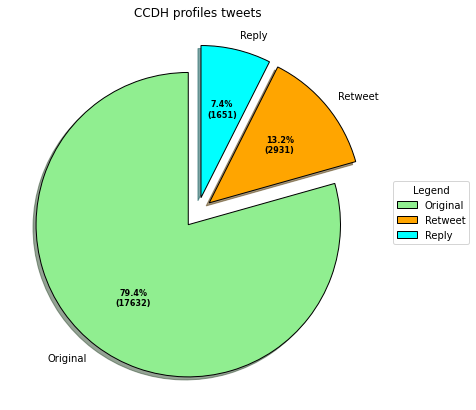

In [41]:
tweets_utils.print_pie_chart3("CCDH profiles tweets","Original","Retweet", "Reply",
      len(ccdh_original["created_at"]), len(ccdh_rt["created_at"]), len(ccdh_reply["created_at"]))

### URL investigation

In [43]:
ccdh_urls = [tweets_utils.url_decompress(v) if v != "[]" else "0" for v in ccdh_urls]
ccdh_urls = list(filter(lambda num: num != "0", ccdh_urls))
ccdh_urls = tweets_utils.remove_www(ccdh_urls)
ccdh_urls

['dlvr.it',
 'youtube.com',
 'foxnews.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'foxnews.com',
 'channelnewsasia.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'youtube.com',
 'twitter.com',
 'twitter.com',
 'nytimes.com',
 'twitter.com',
 'msn.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'forbes.com',
 'nytimes.com',
 'thehill.com',
 'twitter.com',
 'msn.com',
 'twitter.com',
 'twitter.com',
 'reuters.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'politifact.com',
 'politifact.com',
 'twitter.com',
 'twitter.com',
 'bariweiss.substack.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'spectator.co',
 'twitter.com',
 'twitter.com',
 'nytimes.com',
 'twitter.com',
 'yahoo.com',
 'twitter.com',
 'vox.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 'twitter.com',
 

In [1]:
val = pd.Series(ccdh_urls).value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[:30].plot(kind='barh', color='steelblue', fig=(14,14))
ax.set_title('Most original link shared', fontsize=14)
ax.invert_yaxis()
plt.show()

### New URLs
<a id="new_urls"/>

In [104]:
urls_useless = ["youtube.com", "google.com", "youtu.be", "ow.ly", "twitter.com"]

In [128]:
to_remove = []
result = ccdh_urls
val = 0
for i in credibility_url["Domain"]:
    for j in ccdh_urls:
        if j in i:
            to_remove.append(j)
            print(i)
            val = val + 1
x = len(ccdh_urls) - val
new_list = [i for i in result if i not in to_remove]
print(f"Missing urls: {x}")
new_list

In [106]:
for i in new_list:
    for j in urls_useless:
        if j in i:
            new_list.remove(i)

### Classification new domains
<a id="new_domain"/>

In [111]:
credib = []
credib.append("low") #petitions.whitehouse.gov --> è una petizione
credib.append("low") #NaturalNews.com --> CONSPIRACY-PSEUDOSCIENCE
credib.append("high") #heritage.org --> medium, Pseudoscience
credib.append("high") #tampabay.com --> LEFT-CENTER BIAS
credib.append("low") #unherd.com --> online social media 
credib.append("low") #AskDrButtar.com --> Medico osteopatico americano
credib.append("high") #wsws.org --> LEFT BIAS
credib.append("low") #n5ti.com --> news websites operated by a team of volunteers for Ghana
credib.append("low") #theepochtimes.com --> QUESTIONABLE SOURCE
credib.append("high") #covipass.com --> provider trasferimento informazioni sanitarie personali 
credib.append("low") #fort-russ.com --> LEFT-CENTER BIAS (high, to modify) 
credib.append("high") #fiercepharma.com --> No data
credib.append("low") #tenthamendmentcenter.com --> QUESTIONABLE SOURCE
credib.append("low") #vigiliae.org --> not found
credib.append("low") #sun-sentinel.com --> (high, to modify)
credib.append("high") #clinicaltrials.gov -->  registro di studi clinici
credib.append("low") #Reason.com --> RIGHT-CENTER BIAS (high, to modify)
credib.append("low") #childrenshealthdefense.org --> CONSPIRACY-PSEUDOSCIENCE
credib.append("low") #AdvancedMedicineConference.com --> conference
credib.append("high") #aol.com --> LEFT-CENTER BIAS
credib.append("low") #trendingpolitics.com --> QUESTIONABLE SOURCE
credib.append("low") #charityauctionstoday.com --> online auctions

In [115]:
df = pd.DataFrame(list(zip(new_list, credib)),
               columns =['Domain', 'Class'])

In [120]:
new_credibiliy = credibility_url.append(df, ignore_index=True)

In [123]:
new_credibiliy.to_csv("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/domain_credibility.csv", index=False)

### Credibility
<a id="credibility"/>

In [2]:
importlib.reload(tweets_utils)
list_credibility = tweets_utils.check_credibility(ccdh_urls, credibility_url)

In [5]:
list_credibility

### Date tweets
<a id="dates" />

In [ ]:
date = []
for i in ccdh_tweets:
    date.append(tweets_utils.process_datetime(i))
    

In [72]:
fig = px.histogram(tweet_creation)
fig.update_layout(
    title_text='Daily tweets', # title of plot
    xaxis_title_text='Tweet', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()


### Network
<a id="network" />

In [13]:
path = "C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/"
df_rt_ccdh = pd.read_csv(path + "ccdh_retweets.csv")

In [14]:
df_rt_ccdh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103739 entries, 0 to 103738
Data columns (total 49 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         103739 non-null  int64  
 1   id_str                     103739 non-null  int64  
 2   created_at                 103739 non-null  object 
 3   user_id                    103739 non-null  int64  
 4   user_screen_name           103739 non-null  object 
 5   user_verified              103739 non-null  bool   
 6   user_created_at            103739 non-null  object 
 7   user_tweets_count          103739 non-null  int64  
 8   user_friends_count         103739 non-null  int64  
 9   user_followers_count       103739 non-null  int64  
 10  text                       103739 non-null  object 
 11  source                     103739 non-null  object 
 12  coordinates                0 non-null       float64
 13  is_quote_status            10

In [15]:
retweets_graph = nx.from_pandas_edgelist(df_rt_ccdh,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph())
print(nx.info(retweets_graph))

Name: 
Type: DiGraph
Number of nodes: 39713
Number of edges: 55154
Average in degree:   1.3888
Average out degree:   1.3888


In [16]:
degree_dict = dict(retweets_graph.degree(retweets_graph.nodes()))
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [17]:
n=5
print("Top n nodes by degree:")
for d in sorted_degree[:n]:
    print(f"the node with name {d[0]} , has a degree of {d[1]}")

Top n nodes by degree:
the node with name RobertKennedyJr , has a degree of 18291
the node with name mercola , has a degree of 10148
the node with name unhealthytruth , has a degree of 5055
the node with name DeniceMarin , has a degree of 3180
the node with name DrButtar , has a degree of 2604


In [18]:
in_degree_dict = dict(retweets_graph.in_degree(retweets_graph.nodes()))
sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True)

In [19]:
n=5
print("Top n nodes by in_degree:")
for d in sorted_in_degree[:n]:
    print(f"the node with name {d[0]} , has a in-degree of {d[1]}")

Top n nodes by in_degree:
the node with name RobertKennedyJr , has a in-degree of 18291
the node with name mercola , has a in-degree of 10148
the node with name unhealthytruth , has a in-degree of 4870
the node with name DeniceMarin , has a in-degree of 3180
the node with name DrButtar , has a in-degree of 2604


In [20]:
out_degree_dict = dict(retweets_graph.out_degree(retweets_graph.nodes()))
sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True)

In [21]:
n=5
print("Top n nodes by out_degree:")
for d in sorted_out_degree[:n]:
    print(f"the node with name {d[0]} , has a out-degree of {d[1]}")

Top n nodes by out_degree:
the node with name unhealthytruth , has a out-degree of 185
the node with name bev768 , has a out-degree of 131
the node with name gnoBREAKTHROUGH , has a out-degree of 66
the node with name Marble300 , has a out-degree of 64
the node with name annika1021 , has a out-degree of 49


#### Communities with Louvain modularity

In [23]:
retweets_graph_und = nx.from_pandas_edgelist(df_rt_ccdh,'user_screen_name','rt_user_screen_name')
print(nx.info(retweets_graph_und))

Name: 
Type: Graph
Number of nodes: 39713
Number of edges: 54946
Average degree:   2.7672


In [34]:
best_part = cm.best_partition(retweets_graph_und, random_state=42)

In [35]:
best_part

{'Luis40461853': 0,
 'mercola': 0,
 'Dorunda': 1,
 'richardfinnman': 0,
 'psipika': 2,
 'BharatT60678892': 0,
 'Sorothavy': 3,
 'BeautBoulevards': 0,
 'KhephriThoth': 4,
 '0Factsoverfear2': 0,
 'cateschroed': 5,
 'GiveUsAQuid': 6,
 'DeniceMarin': 6,
 'jscotk': 0,
 'Yoshi13113486': 2,
 'JoseGal67300306': 2,
 'PanovT99': 2,
 'dfwdeals': 0,
 'HarrissFiona': 0,
 'DarthGNZ': 0,
 'marisolluzsol': 6,
 'jnutzglass': 0,
 'sasyaquiqe': 0,
 'Max69085812': 0,
 'aileensander': 7,
 'bev768': 7,
 'cactusapinyona': 7,
 'Ex_Supra_9': 0,
 'Mikegrab2': 0,
 'JohnWalshOnline': 0,
 'Wkyhilltopper': 0,
 'Aziz64836924': 0,
 'trooper2050': 0,
 'Tweetweetbeyoch': 8,
 'Angelakg5': 9,
 'amyharlib': 3,
 'MiguelNBarajas2': 6,
 'sweetjlowe': 7,
 'tanyacoleart': 2,
 'Latifa2390': 6,
 'cherylcaby': 7,
 'Thamizhan74': 7,
 'iMedTalk': 6,
 'gloriag23': 10,
 'arroyomatteucc1': 10,
 'bwhatiwill2b': 0,
 'tendrilita': 11,
 'Very_0wn': 2,
 'PeaceablyA': 7,
 'LaboralyRRHH': 0,
 'bereginya5': 2,
 'gasiber': 10,
 'Rosebud2873379

#### Communities with Leiden

In [26]:
tuples = [tuple(x) for x in df_rt_ccdh.values]
retweets_graph = ig.Graph.TupleList(tuples, directed = True)

In [27]:
n_vertices = retweets_graph.vcount()
print("Number of vertices:", n_vertices)
print("Number of edges:", retweets_graph.ecount())
print("Density of the graph:", 2*retweets_graph.ecount()/(retweets_graph.vcount()*(retweets_graph.vcount()-1)))

Number of vertices: 103735
Number of edges: 103739
Density of the graph: 1.928082518348424e-05


In [28]:
total_degree=0
total_indegree = 0
total_outdegree = 0
for n in range(n_vertices):
    total_degree += retweets_graph.degree(n)
    total_indegree += retweets_graph.indegree(n)
    total_outdegree += retweets_graph.outdegree(n)
print("Average indegree:", total_indegree/n_vertices)
print("Average indegree:", total_outdegree/n_vertices)

Average indegree: 1.0000385597917771
Average indegree: 1.0000385597917771


In [29]:
partition = la.find_partition(retweets_graph, la.ModularityVertexPartition)
partition

In [30]:
retweets_graph.vs[0]['name']

1424933544229580812

In [31]:
retweets_graph.vs()["name"]

[1424933544229580812,
 1424914837163892736,
 1424934389272678401,
 1424898609414291456,
 1424982702378287109,
 1424938222270836736,
 1424952308123652096,
 1424941477369630730,
 1424972778688507906,
 1424951200793776135,
 1424965664851251200,
 1424903564816756737,
 1424938166029484037,
 1424938928964993026,
 1424926346124439567,
 1424915246997811216,
 1424936610764927006,
 1424913790106316808,
 1424911330503364615,
 1424936154789556239,
 1424953901942394883,
 1424958597029515264,
 1424933645534437381,
 1424936877463900161,
 1424896752860213248,
 1424955419273875471,
 1424906443317207041,
 1424918463571652608,
 1424946055444013062,
 1424974926440632323,
 1424902666510077955,
 1424956578256539655,
 1424957714267000833,
 1424965928031330306,
 1424940039146983437,
 1424916752425623556,
 1424935769710506033,
 1424927667854331908,
 1424902449995816960,
 1424910882736324611,
 1424947274342445059,
 1424932694333566976,
 1424934348604780544,
 1424911532144668673,
 1424975851578331136,
 142491694

In [32]:
partition.membership

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [33]:
zip_iterator = zip(retweets_graph.vs()["name"], partition.membership)
best_part = dict(zip_iterator)
best_part

{1424933544229580812: 0,
 1424914837163892736: 1,
 1424934389272678401: 2,
 1424898609414291456: 3,
 1424982702378287109: 4,
 1424938222270836736: 5,
 1424952308123652096: 6,
 1424941477369630730: 7,
 1424972778688507906: 8,
 1424951200793776135: 9,
 1424965664851251200: 10,
 1424903564816756737: 11,
 1424938166029484037: 12,
 1424938928964993026: 13,
 1424926346124439567: 14,
 1424915246997811216: 15,
 1424936610764927006: 16,
 1424913790106316808: 17,
 1424911330503364615: 18,
 1424936154789556239: 19,
 1424953901942394883: 20,
 1424958597029515264: 21,
 1424933645534437381: 22,
 1424936877463900161: 23,
 1424896752860213248: 24,
 1424955419273875471: 25,
 1424906443317207041: 26,
 1424918463571652608: 27,
 1424946055444013062: 28,
 1424974926440632323: 29,
 1424902666510077955: 30,
 1424956578256539655: 31,
 1424957714267000833: 32,
 1424965928031330306: 33,
 1424940039146983437: 34,
 1424916752425623556: 35,
 1424935769710506033: 36,
 1424927667854331908: 37,
 1424902449995816960: 